This notebook allows one to estimate the compute involved in training a model.

### Load libraries

In [1]:
import pathlib
from typing import Iterable, Mapping, Optional

import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import pandas as pd
import utils
from sgf_parser import game_info

plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("1-col")]
)

### Load training run data

In [2]:
def get_game_infos(data_dir: str):
    sgf_paths = game_info.find_sgf_files(root=pathlib.Path(f"{data_dir}/selfplay"))
    return game_info.read_and_parse_all_files(
        sgf_paths,
        fast_parse=True,
    )

In [3]:
# Training run for passing adversary
df_pass = pd.DataFrame(
    get_game_infos(
        "/nas/ucb/tony/go-attack/training/emcts1-curr/cp127-to-505-v1",
    )
)
print(len(df_pass))

201896


In [4]:
# Training run for cyclic adversary
# https://www.notion.so/chaiberkeley/adv-b6-600-vs-avoid-pass-alive-v1-curriculum-start-at-cp39-again-ba7cb9bd348d409db3e6fb9c89a56227
df_cyclic = pd.DataFrame(
    get_game_infos(
        "/nas/ucb/k8/go-attack/victimplay/ttseng-avoid-pass-alive-coldstart-39-20221025-175949",
    )
)
print(len(df_cyclic))

1015904


### Estimate compute

In [5]:
# Computed in the estimate-flops-katago.ipynb notebook
# (output of Cell 8, also stored in a global variable called MACS_DICT)
# The (random: 0 is added by us here).
MACS_DICT = {
    "b10c128": 1052902056.7067871,
    "b15c192": 3535965536.369873,
    "b20c256": 8392483407.783936,
    "b40c256": 16703260895.197998,
    "b60c320": 38884293414.61206,
    "b6c96": 350317665.0437012,
} | {"random": 0}


def compute_flops(
    info: pd.Series,
    adv_net_size: str,
    verbose: bool = False,
) -> float:
    """
    Given a game info dict turned into a pandas dataframe row,
    returns the number of flops used in that game.

    Assumes a constant adv_net_size.
    """

    if info.adv_name == "random":
        adv_net_size = "random"
    assert adv_net_size in MACS_DICT

    adv_visits: int = int(info.adv_visits) if info.adv_visits is not None else 600

    victim_net_size: str = info.victim_name.split("-")[2]  # type: ignore
    if victim_net_size.endswith("x2"):
        victim_net_size = victim_net_size[:-2]
    victim_visits: int = int(info.victim_visits)

    num_moves: int = int(info.num_moves)
    adv_moves = num_moves / 2
    victim_moves = num_moves / 2

    # For A-MCTS-S, we assume half the nodes are adversary and half are victim.
    # This is only approximately true due to things like NN-cache effects,
    # terminal nodes not taking any compute, etc.
    adv_macs = (
        adv_moves
        * adv_visits
        * ((MACS_DICT[adv_net_size] + MACS_DICT[victim_net_size]) / 2)
    )

    victim_macs = victim_moves * victim_visits * MACS_DICT[victim_net_size]

    if verbose:
        print("adv:", adv_net_size, adv_visits)
        print("victim:", victim_net_size, victim_visits)
        print("# moves:", num_moves)
        print("adv macs:", adv_macs)
        print("victim macs:", victim_macs)

    # 2 flops per MAC
    tot_flops = 2 * (adv_macs + victim_macs)
    return tot_flops


print(compute_flops(df_pass.iloc[135010], adv_net_size="b6c96", verbose=True))
print()
print(compute_flops(df_cyclic.iloc[50], adv_net_size="b6c96", verbose=True))

adv: b6c96 600
victim: b40c256 1
# moves: 61
adv macs: 156040243826211.56
victim macs: 509449457303.53894
313099386567030.2

adv: b6c96 600
victim: b40c256 8
# moves: 373
adv macs: 954147720445523.1
victim macs: 24921265255635.414
1958137971402317.0


In [6]:
df_pass["flops"] = df_pass.apply(
    lambda info: compute_flops(info, adv_net_size="b6c96"), axis=1
)
df_cyclic["flops"] = df_cyclic.apply(
    lambda info: compute_flops(info, adv_net_size="b6c96"), axis=1
)

In [7]:
def count_rows_and_moves(df: pd.DataFrame):
    tot_moves = df.num_moves.sum()
    tot_rows = (
        df.query("adv_name != 'random'")
        .adv_name.str.split("-")
        .str[2]
        .str.lstrip("d")
        .astype(int)
        .max()
    )

    # There are roughly 2x as many moves as rows,
    # since we only train on moves made by the adversary.
    print("Tot moves:", tot_moves)
    print("Tot rows:", tot_rows)
    print("Moves / row:", tot_moves / tot_rows)


print("Pass run stats")
count_rows_and_moves(df_pass)

print()
print("Def run stats")
count_rows_and_moves(df_cyclic)

Pass run stats
Tot moves: 22254080
Tot rows: 15021246
Moves / row: 1.481506926922041

Def run stats
Tot moves: 305392535
Tot rows: 137006591
Moves / row: 2.2290353534889427


In [8]:
print("Pass adversary: Total FLOPs")
print(df_pass.flops.sum())
print()
print("Cyclic adversary: FLOPs up to playing against victim with 256 moves")
print(df_cyclic.query("victim_visits <= 256").flops.sum())
print()
print("Def run: FLOPs up to 1mil visit experiment adversary")
print(df_cyclic.query("adv_steps <= 545065216").flops.sum())

Pass adversary: Total FLOPs
1.1250468648354182e+20

Cyclic adversary: FLOPs up to playing against victim with 256 moves
1.1329017919681136e+21

Def run: FLOPs up to 1mil visit experiment adversary
9.579539505273748e+21


### Pass-adversary: Training steps vs. FLOPs

In [9]:
def get_victim_active_ranges(df: pd.DataFrame) -> dict[str, tuple[int, int]]:
    """Get victims' active ranges during training."""
    df = df[df.gtype == "normal"]
    df = df[df.board_size == 19]
    df["victim_name_v2"] = (
        df.victim_name.str.strip("kata1-").str.strip(".bin.gz").str.strip(".txt.gz")
        + "-v"
        + df.victim_visits.astype("str")
    )

    grouped_df = df[["victim_name_v2", "adv_steps"]].groupby("victim_name_v2")
    min_dict = grouped_df.adv_steps.min()
    max_dict = grouped_df.adv_steps.max()

    victim_ranges: dict[str, tuple[int, int]] = {}
    for v in df.victim_name_v2.unique():
        start = min_dict[v]
        end = max_dict[v]
        victim_ranges[v] = (start, end)
    victim_ranges = dict(sorted(victim_ranges.items(), key=lambda x: x[1][1]))
    return victim_ranges


def get_victim_change_steps(df: pd.DataFrame) -> list[int]:
    """Get steps at which victim changes during training."""
    return [r[0] for r in get_victim_active_ranges(df).values()]


def make_plot(
    df: pd.DataFrame,
    adv_name: str,
    highlighted_point_step: Optional[int] = None,
) -> tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]:
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    fig, axs = plt.subplots(1, 1)

    cum_flops = df.groupby("adv_steps").flops.sum().sort_index().cumsum()
    cum_flops.plot()
    if highlighted_point_step is not None:
        plt.plot(
            highlighted_point_step,
            cum_flops.loc[highlighted_point_step].item(),
            "D",
            color=colors[0],
        )

    victim_change_steps = get_victim_change_steps(df)
    max_step = df.adv_steps.max()
    for xc in victim_change_steps:
        if xc > 0 and xc < max_step:
            plt.axvline(x=xc, ls=":", lw=1, color=colors[3])

    plt.ylabel("FLOPs (upper bound)")
    plt.xlabel(f"{adv_name}-adversary training steps")

    return fig, axs

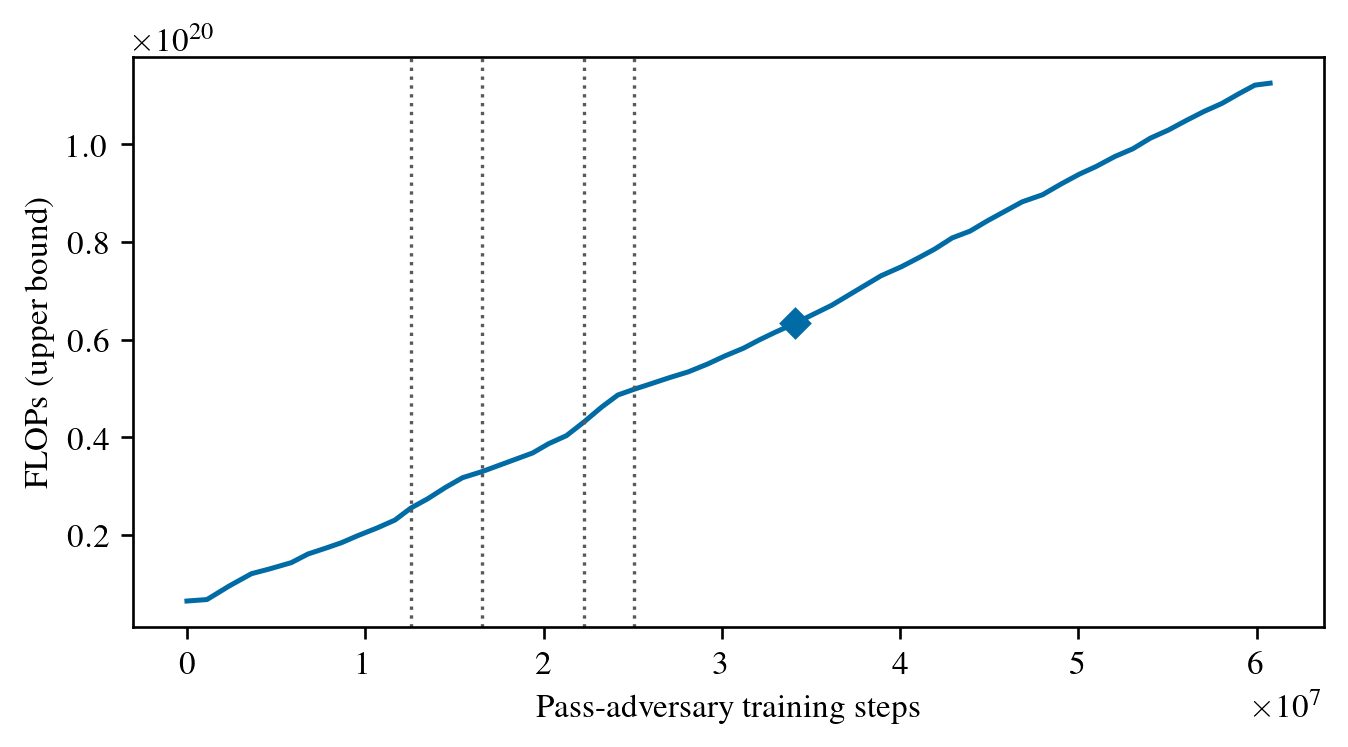

In [10]:
fig, _ = make_plot(
    df_pass,
    adv_name="Pass",
    highlighted_point_step=34090496,
)
fig.savefig("compute-vs-steps-pass.pgf", backend="pgf")

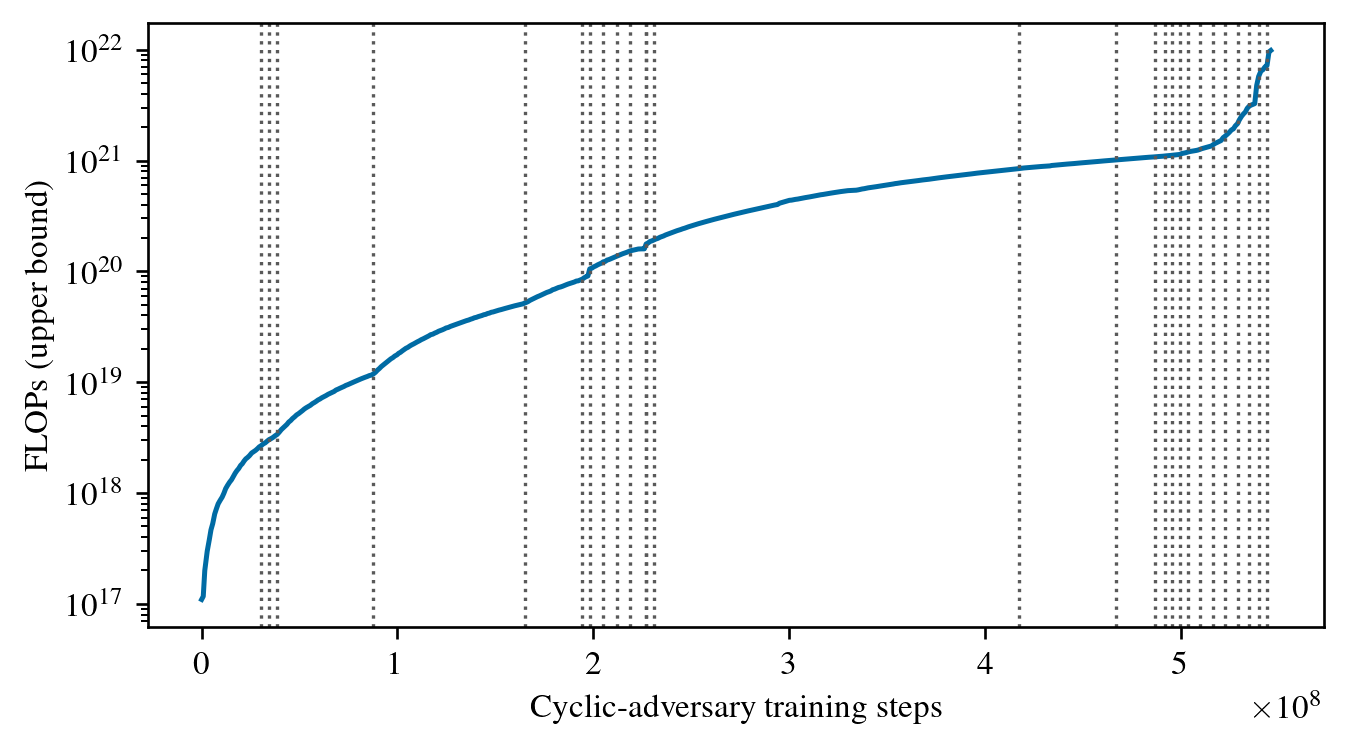

In [11]:
fig, _ = make_plot(df_cyclic, adv_name="Cyclic")
plt.yscale("log")
fig.savefig("compute-vs-steps-cyclic.pgf", backend="pgf")